# 4.1 – Support Vector Machines
In this notebook, we will explore the theoretical foundation of the Support Vector Machine (SVM) algorithm. Our focus will be on the concept of the maximum margin classifier, which lies at the core of SVMs. We will explain how SVMs find the optimal hyperplane that best separates data into distinct classes by maximizing the margin between them.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm  import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

%config InlineBackend.figure_format = 'retina'

In [2]:
data = pd.read_csv('/Users/konansul/Desktop/course-ml/DATA/mouse_viral_study.csv')

In [3]:
data

,Med_1_mL,Med_2_mL,Virus Present
0,6.508231,8.582531,0
1,4.126116,3.073459,1
2,6.427870,6.369758,0
3,3.672953,4.905215,1
4,1.580321,2.440562,1
...,...,...,...
395,2.884122,3.271748,1
396,7.290855,9.488672,0
397,7.895325,8.272529,0
398,2.690592,2.674979,1


In this study, we analyze data from an experiment involving mice and two types of medicaments. The goal is to understand whether the quantities of these medicaments affect the presence of a virus in the mice.

The dataset contains: `Med_1_mL` – Amount of Medicament 1, `Med_2_mL`: Amount of Medicament 2 in milliliters, and `Virus Present` – target variable (1 = Virus Present, 0 = No Virus). Since the set of target variables contains only two values, that is 0 and 1, this is the classification task.

From the scatter plot below, we observe a clear pattern: Mice that received higher doses of both medicaments typically do not have the virus (Virus Present = 0) and mice that received lower doses tend to be infected (`Virus Present = 1`). This pattern makes the problem well-suited for a support vector machine classifier, which will learn the optimal decision boundary (hyperplane) that best separates the two classes.

<Axes: xlabel='Med_1_mL', ylabel='Med_2_mL'>

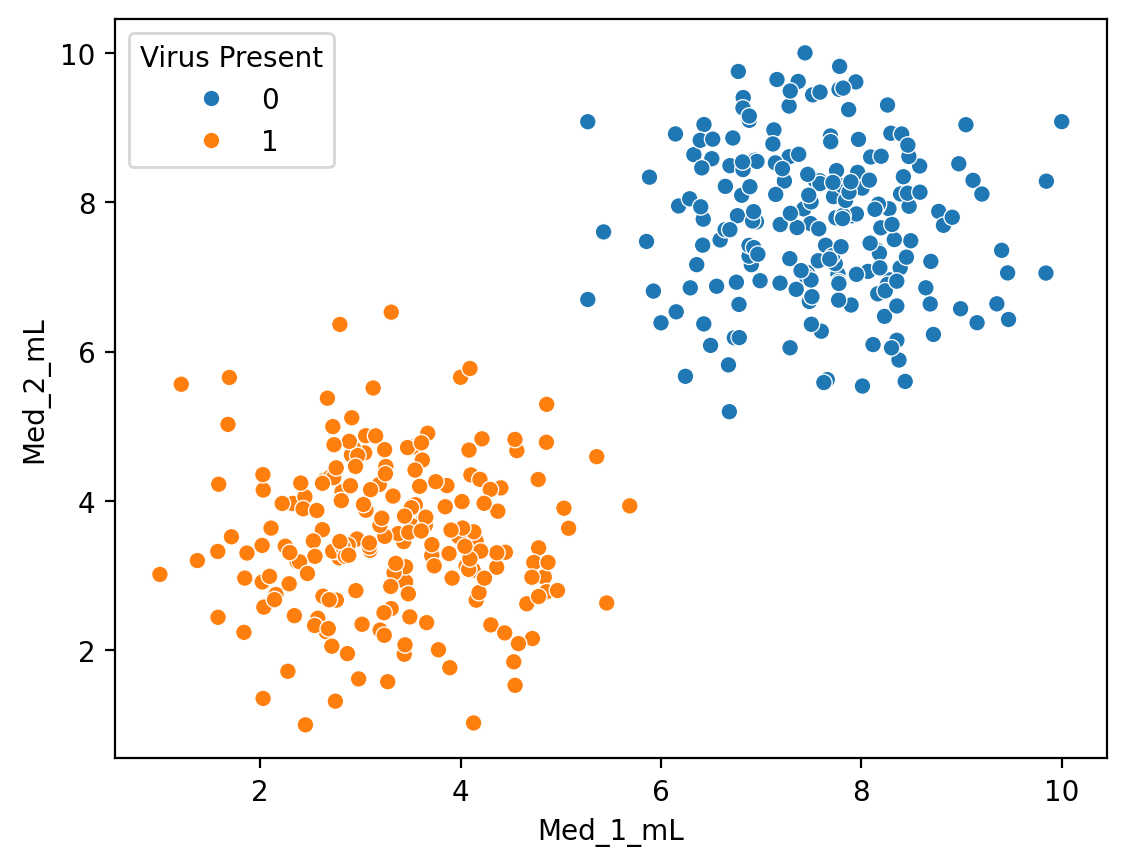

In [4]:
sns.scatterplot(x = 'Med_1_mL', y = 'Med_2_mL', hue = 'Virus Present', data = data)

A **hyperplane** is a flat affine subspace that divides an $n$-dimensional space into two parts. It always has one dimension less than the space it resides in that is $n-1$. For example for one dimension, a hyperplane is a point, for two dimensions, a hyperplane is a line, just like in our case, in three dimensions, a hyperplane is a two dimensional plane, and so on. While we can't easily visualize hyperplanes in more than 3 dimensions, the mathematical principles behind them still hold and are very effective.

In our case, since our dataset has two features, we are working in a 2-dimensional space, and our hyperplane will be a line that separates the two classes (`Virus Present = 0` and `Virus Present = 1`).

But there can be infinitely many hyperplanes that separate the classes. The key question is to choose which of the possible hyperplanes is the best one for separating the data? The Support Vector Machine (SVM) algorithm, chooses the one that maximizes the margin, that is, the distance between the hyperplane and the nearest points from both classes called support vectors.

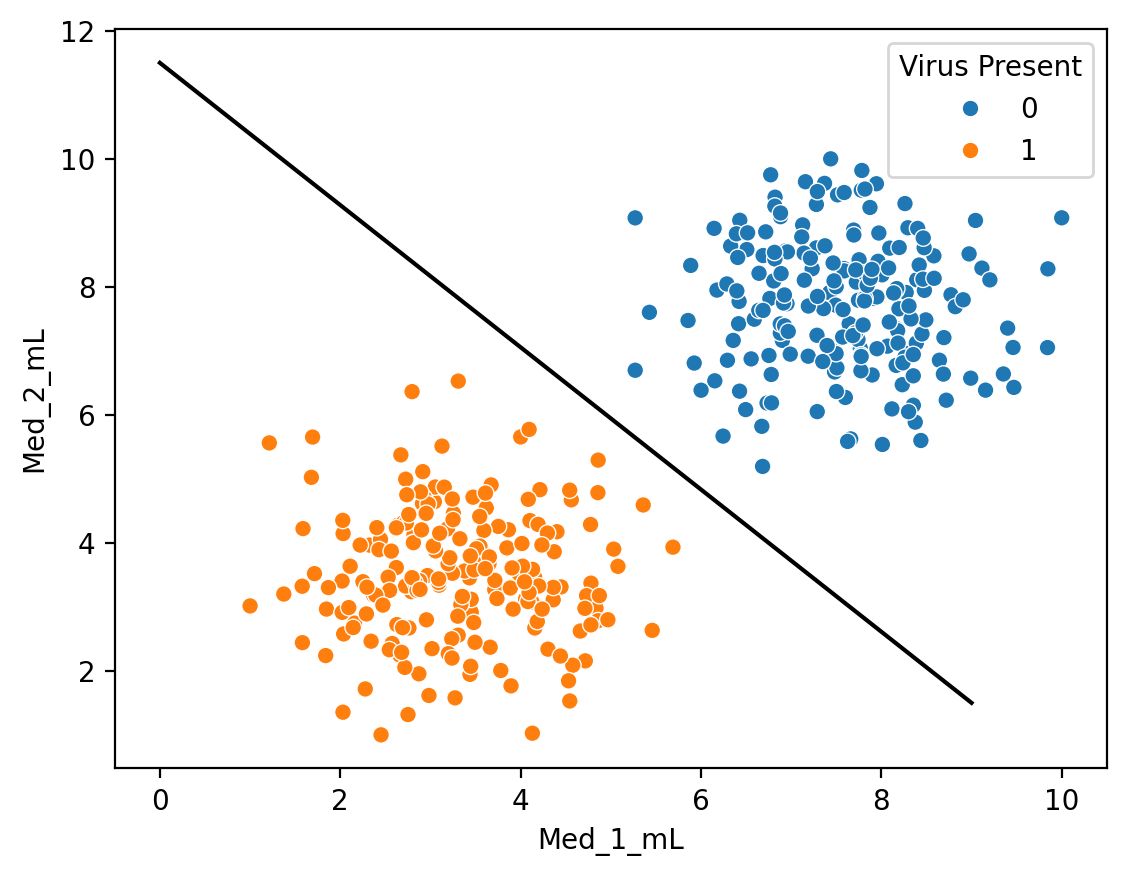

In [5]:
sns.scatterplot(x = 'Med_1_mL', y = 'Med_2_mL', hue = 'Virus Present', data = data)
x = np.linspace(0, 10, 10)
m = -1
b = 11.5
y = m * x + b
plt.plot(y, color = 'black')

Let’s write the decision boundary (hyperplane) in explicit form:

$$
\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p = 0
$$

Or in vector form:

$$
\mathbf{\beta} \cdot \mathbf{x} + \beta_0 = 0
$$

where:
- $\mathbf{x} = (x_1, x_2, \dots, x_p)$ is the feature vector
- $\mathbf{\beta} = (\beta_1, \beta_2, \dots, \beta_p)$ is the weight (normal) vector
- $\beta_0$ is the bias (intercept) term

The classification rule is:
- If $\mathbf{\beta} \cdot \mathbf{x} + \beta_0 > 0$, that is, predicting class 1.
- If $\mathbf{\beta} \cdot \mathbf{x} + \beta_0 < 0$, that is, predicting class 0.

he SVM algorithm defines two supporting hyperplanes:
	•	One on the positive side: $ \mathbf{\beta} \cdot \mathbf{x} + \beta_0 = 1 $
	•	One on the negative side: $ \mathbf{\beta} \cdot \mathbf{x} + \beta_0 = -1 $
    
The distance from any point $\mathbf{x}$ to the hyperplane $\mathbf{\beta} \cdot \mathbf{x} + \beta_0 = 0$ is given by:

$$
\text{Distance} = \frac{|\mathbf{\beta} \cdot \mathbf{x} + \beta_0|}{\|\mathbf{\beta}\|}
$$

The margin is twice this distance because it's measured from the closest points on both sides (one from each class), hence the factor 2.

$$
\text{Margin} = \frac{(1) - (-1)}{\|\mathbf{\beta}\|} = \frac{2}{\|\mathbf{\beta}\|}
$$

To preserve linearity and write both class constraints in one formula, we multiply each constraint by the true class label $y_i \in \{-1, +1\}$:

$$
y_i (\mathbf{\beta} \cdot \mathbf{x}_i + \beta_0) \geq 1
$$

This ensures that:
If $y_i = 1$, then $\mathbf{\beta} \cdot \mathbf{x}_i + \beta_0 \geq 1$
If $y_i = -1$, then $\mathbf{\beta} \cdot \mathbf{x}_i + \beta_0 \leq -1$

This single inequality ensures that each point is on the correct side of the margin.

Our goal is to maximize the margin, which is equivalent to minimizing the norm of the weight vector:

$$
\min_{\mathbf{\beta}, \beta_0} \ \frac{1}{2} \|\mathbf{\beta}\|^2
$$

Subject to the constraint:

$$
y_i (\mathbf{\beta} \cdot \mathbf{x}_i + \beta_0) \geq 1 \quad \text{for all } i
$$

This is a convex quadratic optimization problem with linear constraints. To solve this constrained optimization, we introduce Lagrange multipliers $\alpha_i \geq 0$ for each constraint, and define the Lagrangian:

$$
L(\mathbf{\beta}, \beta_0, \alpha) = \frac{1}{2} \|\mathbf{\beta}\|^2 - \sum_{i=1}^{n} \alpha_i \left[ y_i (\mathbf{\beta} \cdot \mathbf{x}_i + \beta_0) - 1 \right]
$$

We then solve for the saddle point of $L$:
- Minimize with respect to $\mathbf{\beta}, \beta_0$
- Maximize with respect to $\alpha_i$

This yields the dual problem, which is often easier to solve (especially when using kernels):

$$
\max_{\alpha} \sum_{i=1}^{n} \alpha_i - \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} \alpha_i \alpha_j y_i y_j (\mathbf{x}_i \cdot \mathbf{x}_j)
$$

Subject to:

$$
\sum_{i=1}^{n} \alpha_i y_i = 0 \quad \text{and} \quad \alpha_i \geq 0
$$

Only a few of the $\alpha_i$ are non-zero — their corresponding $x_i$ are the support vectors. Aditionally, here the term
$$
(\mathbf{x}_i \cdot \mathbf{x}_j)
$$
is the dot product between input vectors which is the linear kernel:

$$
K(\mathbf{x}_i, \mathbf{x}_j) = \mathbf{x}_i^\top \mathbf{x}_j 
$$

In [6]:
X = data.drop('Virus Present', axis = 1)

In [7]:
y = data['Virus Present']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

A **kernel** is a function that measures similarity between two data points. It allows SVMs to operate in a high-dimensional feature space without explicitly transforming the data. This is known as the kernel trick, and it enables non-linear decision boundaries. There are four types of kernels in skicit-learn, they are:

1. Linear Kernel  
$$
K(\mathbf{x_i}, \mathbf{x_j}) = \mathbf{x_i}^\top \mathbf{x_j}
$$  
Use when data is linearly separable, just like in our case.

2. Polynomial Kernel  
$$
K(\mathbf{x_i}, \mathbf{x}_j) = (\mathbf{x_i}^\top \mathbf{_j} + c)^d
$$  
Use when data has polynomial structure because it allows flexible complexity via degree $d$

3. RBF (Radial Basis Function)  
$$
K(\mathbf{x_i}, \mathbf{x_j}) = \exp\left(-\gamma \|\mathbf{x_i} - \mathbf{x_j})\|^2\right)
$$  
RBF has general-purpose, powerful for most tasks andmostly used when data is not linearly separable, and additionally it requires tuning $\gamma$. It is the default kernel in scikit-learn.

4. Sigmoid Kernel  
$$
K(\mathbf{x_i}, \mathbf{x_j}) = \tanh(\alpha \mathbf{x_i}^\top \mathbf{x_j} + c)
$$  
Sigmoid is inspired by neural networks and rarely used in practice

You can also can use a custom kernel in scikit-learn, pass a function to `kernel=`.

To find the best-performing Support Vector Machine (SVM) model, we can use Grid Search with cross-validation. This method systematically explores combinations of hyperparameters and evaluates their performance using cross-validation to prevent overfitting.

In this task, we search over four kernel types and multiple values of the regularization parameter C, which controls the trade-off between achieving a low training error and a low testing error. Although it may seem unintuitive, Scikit-learn defines C as the reciprocal of the error penalty. This is a common formulation in many ml libraries, allowing the user to control the strictness of the margin by adjusting C.

C is the inverse of the regularization strength, which means: $C = \frac{1}{\lambda}$

where $\lambda$ is the regularization coefficient that penalizes misclassified training examples. Grid Search evaluates each combination of kernel and C, and selects the best model based on cross-validation accuracy. A small value of C means stronger regularization, allowing more misclassifications and resulting in a wider margin (softer margin). A large value of C means weaker regularization, penalizing misclassifications more and aiming for a stricter separation (harder margin).

In [11]:
svm = SVC() 

In [12]:
parameter_grid = {'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 100, 1000], 
                  'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

In [13]:
grid_model = GridSearchCV(svm, parameter_grid)

In [14]:
grid_model.fit(X, y)

,estimator,SVC()
,param_grid,"{'C': [0.001, 0.01, ...], 'kernel': ['linear', 'rbf', ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,0.001


In [15]:
grid_model.best_params_

{'C': 0.001, 'kernel': 'linear'}

In [16]:
model = SVC(kernel = 'linear', C = 1000)
model.fit(X_train, y_train)

,C,1000
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


The code below, was taken directly from the Scikit-learn documentation (see reference at the end of this notebook). This code visualizes the hyperplane, the margins, the support vectors, and the margin points. By plotting these elements, we can intuitively see whether our SVM model has correctly classified the data and whether the margin is maximized as expected. 

In [17]:
def plot_svm_boundary(model, X, y):
    X = X.values
    y = y.values
    
    plt.scatter(X[:, 0], X[:, 1], c = y, s = 30, cmap = 'coolwarm')

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors = 'k', levels = [-1, 0, 1], alpha = 0.5, linestyles = ['--', '-', '--'])

    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')
    plt.show()

/Users/konansul/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


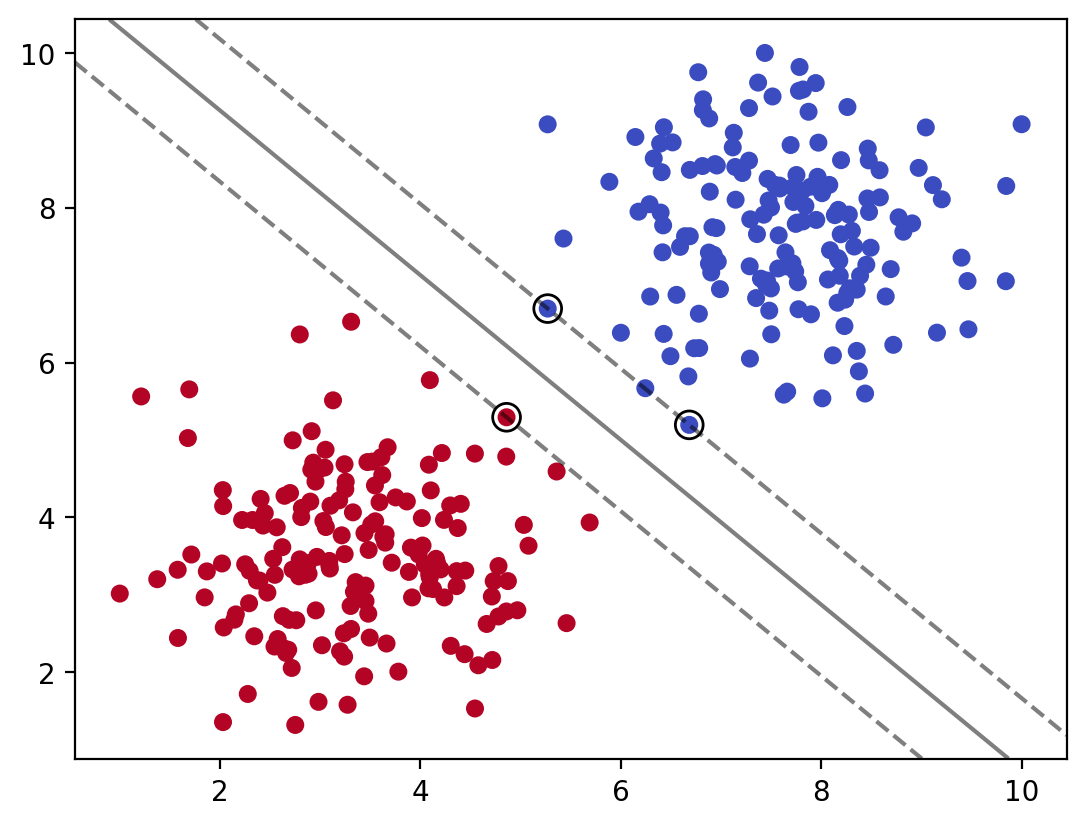

In [18]:
plot_svm_boundary(model, X_train, y_train)

The last steps of this notebook include making predictions on the test dataset, visualizing the decision boundaries, and evaluating the model using a confusion matrix and classification report. As you can see from the output, all the values in the classification report are equal to 1.0 including precision, recall, and F1-score. This means that our model achieved perfect classification on the test set.

However, it is important to note that such perfect performance is rarely seen in real-world scenarios. This may indicate a particularly clean or well-separated dataset, or it could suggest issues such as overfitting or data leakage. In practical machine learning tasks, it is crucial to be cautious of such results and ensure that the evaluation is truly representative of generalization performance.

In [19]:
y_pred = model.predict(X_test)

In [20]:
def plot_metrics(model, x_test, y_test):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, cmap = 'Blues', ax = axes[0])
    RocCurveDisplay.from_estimator(model, x_test, y_test, ax = axes[1])
    PrecisionRecallDisplay.from_estimator(model, x_test, y_test, ax = axes[2])
    axes[0].set_title("Confusion Matrix")
    axes[1].set_title("ROC Curve")
    axes[2].set_title("Precision-Recall Curve")
    plt.tight_layout()
    plt.show()

In [21]:
y_pred

array([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0])

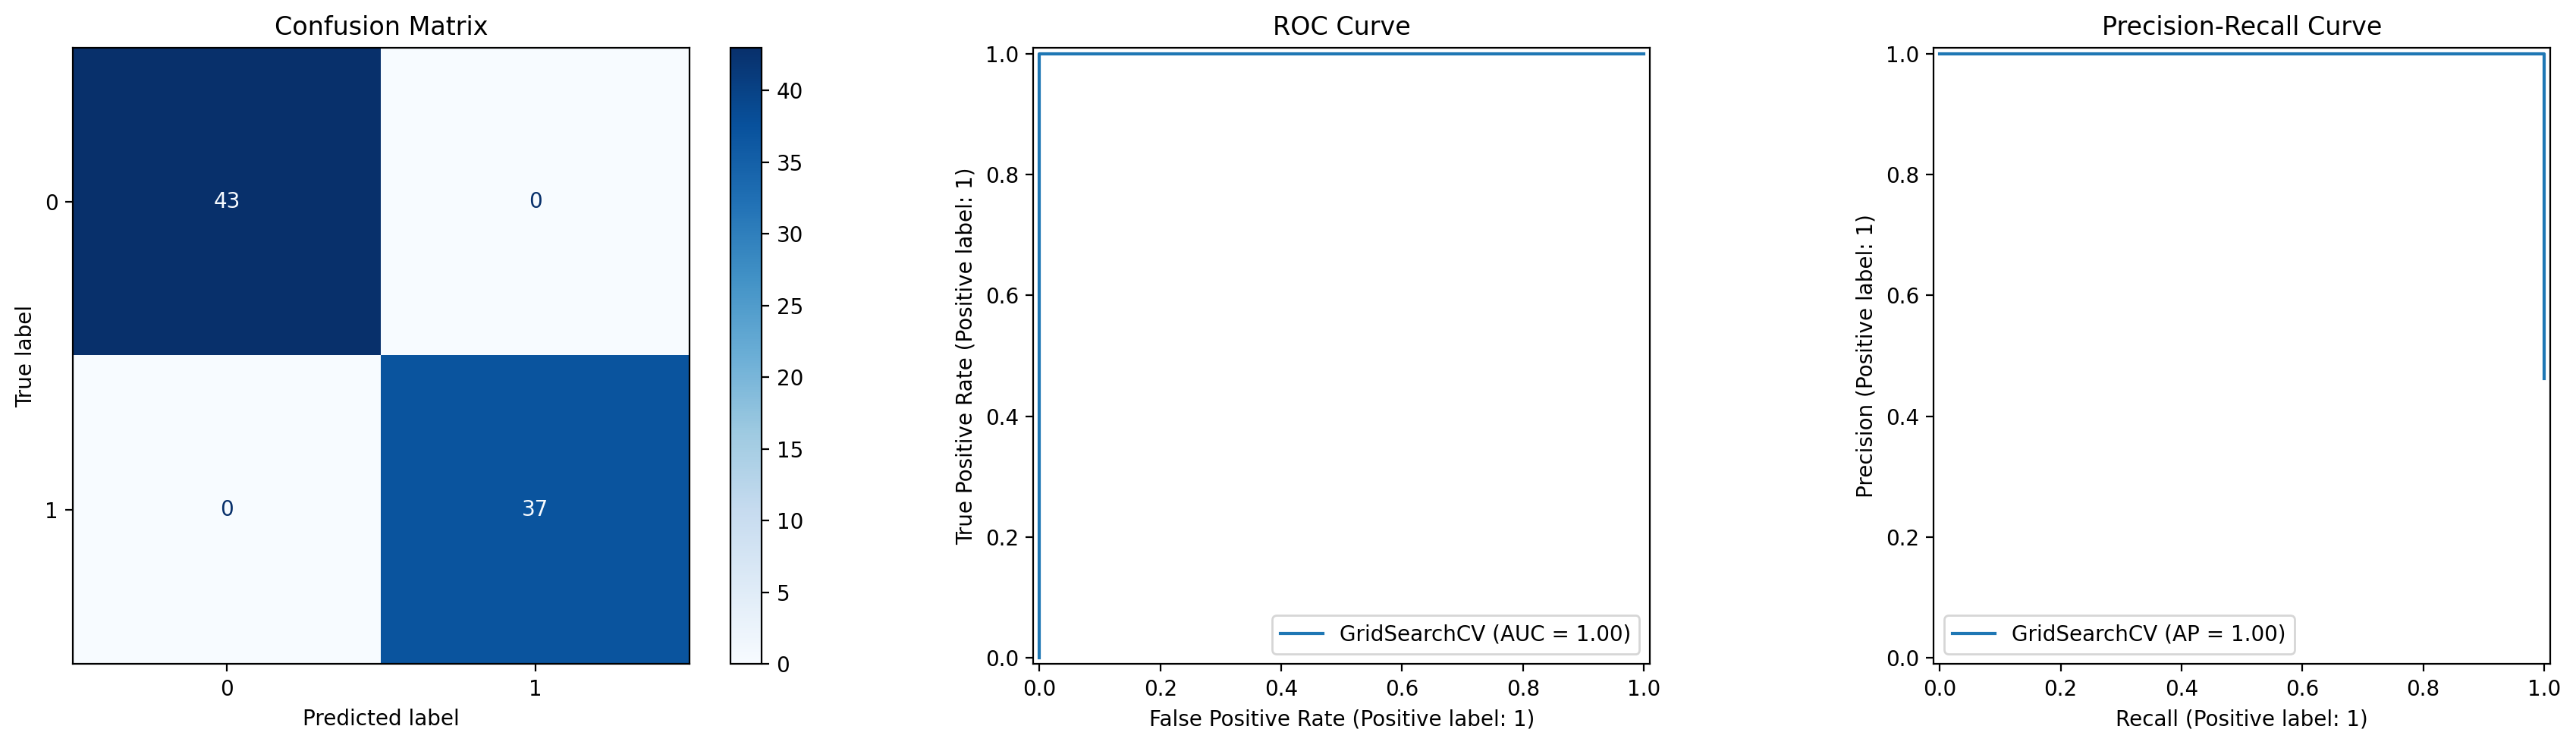

In [22]:
plot_metrics(grid_model, X_test, y_test)

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        37

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



# References
**[1]** Gareth James, Daniela Witten, Trevor Hastie, and Robert Tibshirani. *An Introduction to Statistical Learning with Applications in Python*. Chapter 9: Support Vector Machines. https://www.statlearning.com/

**[2]** http://www.ccas.ru/voron/download/SVM.pdf

**[3]** https://www.kaggle.com/datasets/brsahan/mouse-viral-infection-study-dataset

**[4]** https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html